In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from paren_checker import HighLevelParensBalanceChecker, ParensBalanceDataset
from paren_checker import test_HL_parens_components
test_HL_parens_components()
balance_checker = HighLevelParensBalanceChecker()
sample_dataset = ParensBalanceDataset(N_samples=10, n_ctx=5).get_dataset()
for toks in sample_dataset['str_tokens']:
    print(toks)

All tests passed!
['[BOS]', '(', '[PAD]', '[PAD]', '[PAD]']
['[BOS]', ')', '[PAD]', '[PAD]', '[PAD]']
['[BOS]', '(', '(', '[PAD]', '[PAD]']
['[BOS]', '(', ')', '[PAD]', '[PAD]']
['[BOS]', ')', '(', '[PAD]', '[PAD]']
['[BOS]', ')', ')', '[PAD]', '[PAD]']
['[BOS]', '(', '(', '(', '[PAD]']
['[BOS]', '(', '(', ')', '[PAD]']
['[BOS]', '(', ')', '(', '[PAD]']
['[BOS]', '(', ')', ')', '[PAD]']


In [20]:
from paren_checker import get_LL_parens_model_and_correspondence
ll_model, corr, unused_nodes = get_LL_parens_model_and_correspondence()
print("Model:")
print(ll_model)
print("\nCorrespondence:")
for k, i in corr.items():
    print(k, i)
print("\nUnused:")
for n in unused_nodes:
    print(n)

Model:
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (ho

In [59]:
import torch as t
from siit_utils import ModelTrainerSIIT
from paren_checker import paren_checker_loss_fn as loss_fn



ll_model, corr, unused_nodes = get_LL_parens_model_and_correspondence()
dataset = ParensBalanceDataset(N_samples=800_000, n_ctx=20).get_dataset()

trainer = ModelTrainerSIIT(
    ll_model=ll_model,
    hl_model=balance_checker,
    dataset=dataset,
    corr=corr,
    unused_nodes=unused_nodes,
    loss_fn=loss_fn,
    baseline_weight = 1,
    iit_weight = 1,
    siit_weight = 1,
    batch_size = 256,
    device = 'cuda'
)

results = trainer.train(epochs=1)

Moving model to device:  cuda
Epoch 1/1


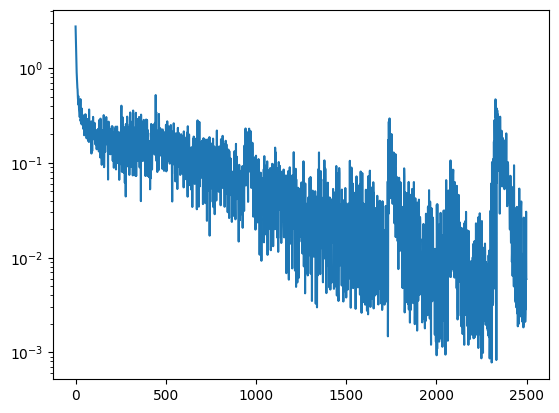

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.semilogy(results['train_loss'])

(0.0, 100.0)

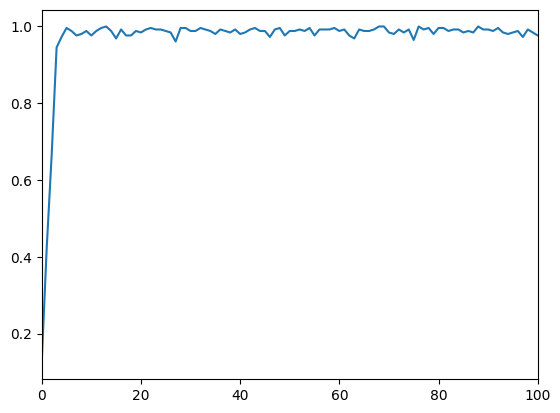

In [63]:
plt.plot(results['train_IIA'])
plt.xlim(0, 100)

# SAE

In [69]:
from paren_checker import create_paren_checker_tokenizer
tokenizer = create_paren_checker_tokenizer()
ll_model.tokenizer = tokenizer #attach to model.

Encoded: [0, 1, 2, 1, 2, 3, 3, 3]
Decoded: BOS ( ) ( ) [PAD] [PAD] [PAD]


In [71]:
from sae_utils import make_sae_lens_config
sae_lens_cfg = make_sae_lens_config(
    model=ll_model, 
    hook_name="blocks.0.attn.hook_z", 
    hook_layer=0, 
    l1_coeff=1e-1,
    hook_head_index=0, 
    context_size=ll_model.cfg.n_ctx,
    d_in=ll_model.cfg.d_head,
    device = 'cuda',
    checkpoint_path = f"$HOME/persistent-storage/tracr_saes/parens_sae_checkpoints",
    wandb_project =  "benchmark_saes",
)

hook_head_index 0
context_size 20
d_in 8
wandb_project benchmark_saes
Run name: 32-L1-0.1-LR-0.0003-Tokens-1.500e+06
n_tokens_per_buffer (millions): 0.0016
Lower bound: n_contexts_per_buffer (millions): 8e-05
Total training steps: 18750
Total wandb updates: 1875
n_tokens_per_feature_sampling_window (millions): 3.2
n_tokens_per_dead_feature_window (millions): 1.6
We will reset the sparsity calculation 9 times.
Number tokens in sparsity calculation window: 1.60e+05
Using Ghost Grads.


In [72]:
from sae_utils import train_sae

sae, store = train_sae(ll_model, sae_lens_cfg, dataset)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/dev/.netrc


Training SAE:   0%|                                                                           | 0/1500000 [00:00<?, ?it/s]/opt/venv/lib/python3.10/site-packages/sae_lens/training/activations_store.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(
3700| MSE Loss 0.019 | L1 0.121:  20%|████████                                 | 296000/1500000 [00:34<02:21, 8535.32it/s]

NameError: name 'os' is not defined